In [176]:
import pandas as pd
from copy import deepcopy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# init df
df = pd.read_csv('https://raw.githubusercontent.com/iad34/seminars/master/materials/data_sem1.csv', sep=';')

In [3]:
# preprocess data
cols = list(df.columns)
a, b = cols.index('Survived'), cols.index('Embarked')
cols[b], cols[a] = cols[a], cols[b]
df = df[cols]

df.drop(["Embarked", "PassengerId", "Cabin", "Ticket", "Name"], axis=1, inplace=True)

df = df.replace({'Sex': {'female': 0, 'male': 1}})

df = df.drop(df[(df.Sex == 'unknown') | (df.Age == 'NaN')].index)

df = df.dropna()

df = df.reset_index(drop=True)

cols = list(df.columns)
a, b = cols.index('Pclass'), cols.index('Age')
cols[b], cols[a] = cols[a], cols[b]
df = df[cols]

cols = list(df.columns)
a, b = cols.index('Fare'), cols.index('Sex')
cols[b], cols[a] = cols[a], cols[b]
df = df[cols]


train_df, test_df = train_test_split(df, test_size=0.2)

x_train, y_train = train_df.to_numpy()[:,:-1], train_df.to_numpy()[:,-1]
x_test, y_test = test_df.to_numpy()[:,:-1], test_df.to_numpy()[:,-1]


std_scaler = StandardScaler().fit(x_train[:, :2])
minmax_scaler = MinMaxScaler().fit(x_train[:, 2:])

def preprocessor(X):
    A = deepcopy(X)
    A[:, :2] = std_scaler.transform(X[:, :2])
    A[:, 2:] = minmax_scaler.transform(X[:, 2:])
    return A

preprocessor_transformer = FunctionTransformer(preprocessor)

p1 = Pipeline([('Scaler', preprocessor_transformer),
              ('Logistic Regression', LogisticRegression())])

y_train=y_train.astype('int')

In [48]:
# training model
p1.fit(x_train, y_train)
train_pred_prob = p1.predict_proba(x_train)
train_pred = p1.predict(x_train)
test_pred = p1.predict(x_test)
train_pred_prob = train_pred_prob[:, 1]

In [87]:
# preparing to ROC
final_prob_target_and_class = np.column_stack([train_pred_prob.T, train_pred.T, y_train.T]).astype(float)

final_prob_target_and_class = final_prob_target_and_class[np.argsort(final_prob_target_and_class[:, 0])]

final_prob_target_and_class = final_prob_target_and_class[::-1]

match = np.zeros((final_prob_target_and_class.shape[0],))

for i in range(final_prob_target_and_class.shape[0]):
    match[i] = final_prob_target_and_class[i, 2]

n = match.sum().astype(int)
m = (match.shape[0]-n).astype(int)

coord_y = np.linspace(0, 1, num = n)
coord_x = np.linspace(0, 1, num = m)
coords = np.zeros((match.shape[0]-1, 2))

h_i = w_i = 0
coords[0] = coord_x[0], coord_y[0]

for i in range(1, n+m-1):
    if match[i] == 1:
        h_i += 1
    else:
        w_i += 1
    coords[i] = coord_x[w_i], coord_y[h_i]

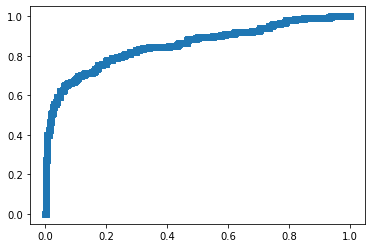

In [187]:
# ROC
plt.scatter(coords[:, 0], coords[:, 1], marker = ",")